
#### Environment setup



In [39]:
begin
	# Activate project environment
	import Pkg
	Pkg.activate(".")
	
	# SciML tools
	import OrdinaryDiffEq, ModelingToolkit, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL, LineSearches, Symbolics
	
    # Standard libraries
	using StatsBase, Plots, CSV, DataFrames, ComponentArrays, JLD2
	
    # Activation function module
	include("RBF.jl")
	using .RBF
	
    # External libraries
	using Lux, Zygote, StableRNGs
	
    # Set a random seed for reproducibility
	rng = StableRNG(1111)
	gr()
end

  Activating project at `~/Documents/Master/MasterThesis/UDE/DataDrivenEquationDiscovery`


Plots.GRBackend()


# UDE approximation
This notebook contains the code to define and solve a Universal Differential Equation (UDE) system, taking inspiration from the SciML tutorial ["Automatically Discover Missing Physics by Embedding Machine Learning into Differential Equations"](https://docs.sciml.ai/Overview/dev/showcase/missing_physics/#Symbolic-regression-via-sparse-regression-(SINDy-based)). Using a neural network as a universal approximator inside an ODE system, the goal is to model unknown components of biological models such as feedback mechanisms. In particular, the Simple Negative Feedback Loop model (NFB) of two kinases g1p and g2p will be used to implement the UDE. It was presented in Chapter 13: Parameter Estimation, Sloppiness, and Model Identifiability by D. Daniels, M. Dobrzyński, D. Fey in "Quantitative Biology: Theory, Computational Methods and Examples of Models" (2018)).




#### Define ODE system for the four following cases:
- no feedback loop
- negative feedback loop of X on g1p
- negative feedback loop of X on g2p
- negative feedback loop of X on g1p and g2p
for a given concentration of input.




In [14]:
begin
	# Set input concentration
	CC = 0.05
	
    # Set NFB type
	nfb_type = "ab"
	
    # Set signal function parameters
	pulse_duration=10
	pulse_frequency=10
	
    # Define the signal function
	f_signal(t) = 1 #sum(tanh(100(t - i))/2 - tanh(100(t - (i + pulse_duration))) / 2 for i in range(0, stop=100, step=(pulse_frequency + pulse_duration)))
	
    # Register the symbolic function
	Symbolics.@register_symbolic f_signal(t)
end

In [40]:
begin
	# Name file to save the results according to parameters used
	CC_string = replace(string(CC), "." => "")
	filename = "nfb_$(nfb_type)_$(CC_string)" 
	
	# Parameter file to save or/and re-use
	save_file = nothing #"./Data/nfb_nn_param_$(nfb_type)_tanh.jld2"
	retrain_file = "./Data/nfb_nn_param_$(nfb_type)_gelu.jld2" 
end

"./Data/nfb_nn_param_ab_gelu.jld2"

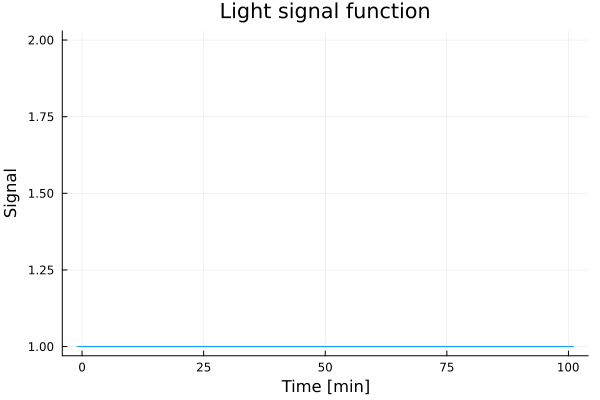

In [16]:
begin
	# Visualise the signal function
	x = LinRange(-1, 101, 1000)
	plot(x, f_signal.(x), xlabel="Time [min]", ylabel="Signal", title="Light signal function", label="")
end

In [17]:
# Define negative feedback ODE system function
function NFB!(du, u, p, t)
	
    # Retrieve known parameters
	v1, v2, v3, v4, v5, v6 = p[1:6]
	k1, k2, k3, k4, k5, k6 = p[7:12]
	α, β, input = p[13:15]
	
    # Define ODE system
	du[1] = v1 * input * f_signal(t) * (1-u[1]) / (k1 + (1-u[1])) - 
			(v2 * u[1] / (k2 + u[1])) * (1 + α * (u[3] - 1))
    du[2] = v3 * u[1] * (1-u[2]) / (k3 + (1-u[2])) - 
			(v4 * u[2] / (k4 + u[2])) * (1 + β * (u[3] - 1))
	du[3] = v5 * u[2] * (1-u[3]) / (k5 + (1-u[3])) - 
			(v6 * u[3] / (k6 + u[3]))
end

NFB! (generic function with 1 method)

In [18]:
begin
	# Define time span and inital conditions of ODE problem
	u0 = repeat([0], 3)
	tspan = (0., 100.)
	
	# Define parameters for no feedback case
	p_noFB = [0.5, 5, 5, 0.03, 0.1, 0.1,
			  0.1, 0.1, 0.1, 0.1, 1, 10,
			  0, 0, 0.08]
	p_noFB[15] = CC
	
    # Define and solve ODE problem for specific case
	prob_noFB = ModelingToolkit.ODEProblem(NFB!, u0, tspan, p_noFB)
	X_noFB = OrdinaryDiffEq.solve(prob_noFB, OrdinaryDiffEq.Vern7(), abstol = 1e-12, reltol = 1e-12, saveat = 0.125)
	model_plot = plot(X_noFB, idxs=2, label="No NFB")
	[]
end

Any[]

In [19]:
begin
	# Define specific parameters for case a
	p_a = copy(p_noFB)
	p_a[13] = 1
	
    # Define and solve ODE problem for specific case a
	prob_a = ModelingToolkit.ODEProblem(NFB!, u0, tspan, p_a)
	X_a = OrdinaryDiffEq.solve(prob_a, OrdinaryDiffEq.Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 0.125) 
	plot!(model_plot, X_a, idxs=2, label="NFB on g1p")
	[]
end

Any[]

In [20]:
begin
	# Define specific parameters for case a
	p_b = copy(p_noFB)
	p_b[14] = 1
	
    # Define and solve ODE problem for specific case b
	prob_b = ModelingToolkit.ODEProblem(NFB!, u0, tspan, p_b)
	X_b = OrdinaryDiffEq.solve(prob_b, OrdinaryDiffEq.Vern7(), abstol = 1e-12, reltol = 1e-12, saveat = 0.125)
	plot!(model_plot, X_b, idxs=2, label="NFB on g2p")
	[]
end

Any[]

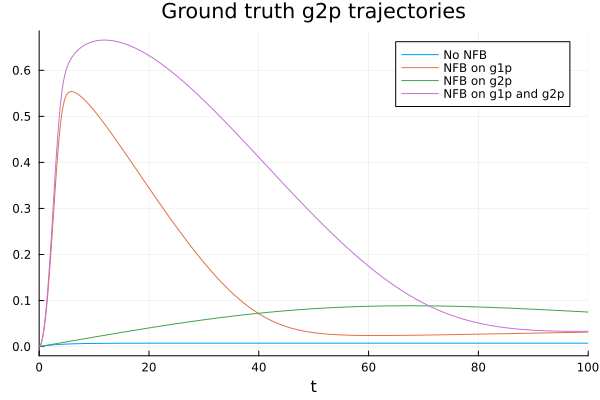

In [21]:
begin
	# Define specific parameters for case ab
	p_ab = copy(p_noFB)
	p_ab[13:14] .= 1
	
    # Define and solve ODE problem for specific case ab
	prob_ab = ModelingToolkit.ODEProblem(NFB!, u0, tspan, p_ab)
	X_ab = OrdinaryDiffEq.solve(prob_ab, OrdinaryDiffEq.Vern7(), abstol = 1e-12, reltol = 1e-12, saveat = 0.125)
	plot!(model_plot, X_ab, idxs=2, label="NFB on g1p and g2p", title="Ground truth g2p trajectories")
end


#### Simulate data with noise



In [22]:
begin
	# Add noise in terms of the mean
	x_g2p_noFB = Array(X_noFB)[2,begin:10:end]
	time = X_noFB.t[begin:10:end]
	
	x̄_g2p_noFB = mean(x_g2p_noFB, dims = 1)
	noise_magnitude = 5e-3
	xₙ_g2p_noFB = abs.(x_g2p_noFB .+ (noise_magnitude * x̄_g2p_noFB) .* randn(rng, eltype(x_g2p_noFB), size(x_g2p_noFB)))
	
	plot(X_noFB, alpha = 0.75, color = :blue, 
		label = "noFB Ground truth", idxs=2, title="g2p simulated data")
	scatter!(time, xₙ_g2p_noFB, color = :blue, label = "noFB Noisy Data", idxs=4)
	[]
end

Any[]

In [23]:
begin
	# Add noise in terms of the mean
	x_g2p_a = Array(X_a)[2,begin:10:end]
	
	x̄_g2p_a = mean(x_g2p_a, dims = 1)
	xₙ_g2p_a = abs.(x_g2p_a .+ (noise_magnitude * x̄_g2p_a) .* randn(rng, eltype(x_g2p_a), size(x_g2p_a)))
	
	plot!(X_a, alpha = 0.75, color = :orange, 
		label = "a Ground truth", idxs=2)
	scatter!(time, xₙ_g2p_a, color = :orange, label = "a Noisy Data", idxs=4)
	[]
end

Any[]

In [24]:
begin
	# Add noise in terms of the mean
	x_g2p_b = Array(X_b)[2,begin:10:end]
	
	x̄_g2p_b = mean(x_g2p_b, dims = 1)
	xₙ_g2p_b = abs.(x_g2p_b .+ (noise_magnitude * x̄_g2p_b) .* randn(rng, eltype(x_g2p_b), size(x_g2p_b)))
	
	plot!(X_b, alpha = 0.75, color = :green, 
		label = "b Ground truth", idxs=2)
	scatter!(time, xₙ_g2p_b, color = :green, label = "b Noisy Data", idxs=4)
	[]
end

Any[]

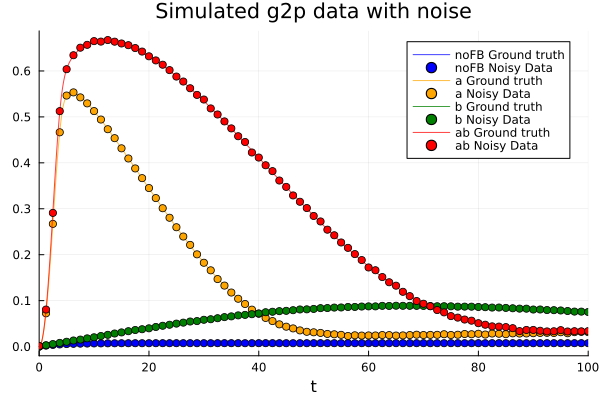

In [25]:
begin
	# Add noise in terms of the mean
	x_g2p_ab = Array(X_ab)[2,begin:10:end]
	
	x̄_g2p_ab = mean(x_g2p_ab, dims = 1)
	xₙ_g2p_ab = abs.(x_g2p_ab .+ (noise_magnitude * x̄_g2p_ab) .* randn(rng, eltype(x_g2p_ab), size(x_g2p_ab)))
	
	plot!(X_ab, alpha = 0.75, color = :red, 
		label = "ab Ground truth", idxs=2)
	scatter!(time, xₙ_g2p_ab, color = :red, label = "ab Noisy Data", title="Simulated g2p data with noise", idxs=4)
end


#### Solve UDE
Solve the UDE problem for a specific case of NFB.



In [41]:
begin
	# Multilayer FeedForward
	const U = Lux.Chain(Lux.Dense(3, 10, gelu), Lux.Dense(10, 10, gelu), Lux.Dense(10, 10, gelu), Lux.Dense(10, 10, gelu), Lux.Dense(10, 2)) 
	#const U = Lux.Chain(Lux.Dense(3, 25, RBF.rbf), Lux.Dense(25, 25, RBF.rbf), Lux.Dense(25, 25, RBF.rbf), Lux.Dense(25, 25, RBF.rbf), Lux.Dense(25, 2))
	
	if !isnothing(retrain_file)
		
		# Load pre-trained NN parameters
		architecture = load(retrain_file)["architecture"]
		p = architecture.p
		const _st = architecture.st
	else
		# Get the initial parameters and state variables of the model
		p, st = Lux.setup(rng, U)
		const _st = st
	end
end

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

In [42]:
# Define the hybrid model
function ode_discovery!(du, u, p, t, p_true)
	
    # Estimate ODE solution with NN
	û = U(u, p, _st)[1] 
	
    # Retrieve known parameters
    v1, v2, v3, v4, v5, v6 = p_true[1:6]
	k1, k2, k3, k4, k5, k6 = p_true[7:12]
	α, β, input = p_true[13:15]
	
    # Define ODE system with unknown part
	du[1] = v1 * input * f_signal(t) * (1-u[1]) / (k1 + (1-u[1])) -  
			(v2 * u[1] / (k2 + u[1])) * û[1]
    du[2] = v3 * u[1] * (1-u[2]) / (k3 + (1-u[2])) - 
			(v4 * u[2] / (k4 + u[2])) * û[2]
	du[3] = v5 * u[2] * (1-u[3]) / (k5 + (1-u[3])) - (v6 * u[3] / (k6 + u[3]))
	
end

ode_discovery! (generic function with 1 method)

In [43]:
begin
	# Closure with the known parameter
	if nfb_type == "a"
		xₙ_g2p = xₙ_g2p_a
		X = X_a
		nn_NFB!(du, u, p, t) = ode_discovery!(du, u, p, t, p_a)
	elseif nfb_type == "b"
		xₙ_g2p = xₙ_g2p_b
		X = X_b
		nn_NFB!(du, u, p, t) = ode_discovery!(du, u, p, t, p_b)
	elseif nfb_type == "ab"
		xₙ_g2p = xₙ_g2p_ab
		X = X_ab
		nn_NFB!(du, u, p, t) = ode_discovery!(du, u, p, t, p_ab)
	else
		xₙ_g2p = xₙ_g2p_noFB
		X = X_noFB
		nn_NFB!(du, u, p, t) = ode_discovery!(du, u, p, t, p_noFB)
	end
	
	# Define the problem
	prob_nn = ModelingToolkit.ODEProblem(nn_NFB!, u0, tspan, p)
end

ODEProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 3-element Vector{Int64}:
 0
 0
 0

In [44]:
function predict(θ, T=time)
    _prob = ModelingToolkit.remake(prob_nn, p = θ)
    Array(OrdinaryDiffEq.solve(_prob, OrdinaryDiffEq.AutoVern7(OrdinaryDiffEq.Rodas5P()), saveat = T,
        abstol = 1e-12, reltol = 1e-12, 
		sensealg=SciMLSensitivity.QuadratureAdjoint(autojacvec=SciMLSensitivity.ReverseDiffVJP(true))))
end

predict (generic function with 2 methods)

In [45]:
function loss(θ)
    X̂ = predict(θ)
	if length(X̂[2,:]) == length(xₙ_g2p)
    	mean(abs2, xₙ_g2p .- X̂[2,:])
	else
		1000
	end
end

loss (generic function with 1 method)

In [46]:
begin
	losses = Float64[]
	track = []
	callback = function(p, l)
	    push!(losses, l)
		#X̂ = predict(p.u)
		#û = U(X̂, p.u, _st)[1]
		#push!(track, (X̂ = X̂, û = û))
	    if length(losses) % 50 == 0
	        @info "Current loss after $(length(losses)) iterations: $(losses[end])"
	    end
	    return false
	end
end

#5 (generic function with 1 method)

In [47]:
begin
	adtype = Optimization.AutoZygote()
	optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
	optprob1 = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(p))
end

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [-0.20413469252969269 -0.8525122409369436 0.4595985389886123; 0.07462143168213303 0.060937632351547935 0.9010455611235272; … ; 0.5532333313657178 0.38824242253956176 0.43441124592636404; 0.018165286838576357 0.17055906792879902 -0.37212369721371386], bias = [0.6818160934638055, -0.16820813944482083, -0.2776714637426409, 0.38339745364868555, -0.33964606945442055, 0.09854633954490687, 0.5357393598302297, -0.16780335632433846, 0.29431454220430225, -0.21004939470463013]), layer_2 = (weight = [-0.10597135732769733 -0.25028654047301546 … 0.4265136326260191 -0.11729328085336448; -0.08820120426592623 0.24836317176177455 … 0.3541235794631223 0.3078086916335165; … ; -0.24599663310506603 -0.39749505098498444 … 0.14008059146153126 -0.320529880804195; -0.16047340270191418 0.6250141812156343 … 0.28675566790946183 -0.20972312446279506], bias = [0.27478181663167645, 0.09191920076639822, 0.27914961287342754, -0.2135345

In [48]:
begin
	# Empty the loss array
	if !isempty(losses)
    	empty!(losses)
		empty!(track)
	end
	res1 = Optimization.solve(optprob1, OptimizationOptimisers.Adam(), callback = callback, maxiters = 100, abstol=1e-10, reltol = 1e-10)
	println("Training loss after $(length(losses)) iterations: $(losses[end])")
end

[ Info: Current loss after 50 iterations: 8.540205945715221e-5
[ Info: Current loss after 100 iterations: 5.296344296907008e-6


Training loss after 100 iterations: 5.296344296907008e-6


In [49]:
begin
	optprob2 = Optimization.OptimizationProblem(optf, res1.u)
	res2 = Optimization.solve(optprob2, OptimizationOptimJL.LBFGS(linesearch = LineSearches.BackTracking()), callback = callback, maxiters = 1000)
	println("Final training loss after $(length(losses)) iterations: $(losses[end])")
end

[ Info: Current loss after 150 iterations: 2.1745687849738403e-6
[ Info: Current loss after 200 iterations: 2.1457280850549468e-6
[ Info: Current loss after 250 iterations: 2.142175953681547e-6
[ Info: Current loss after 300 iterations: 2.127827005850808e-6
[ Info: Current loss after 350 iterations: 2.126139409959595e-6
[ Info: Current loss after 400 iterations: 2.1210442594742595e-6
[ Info: Current loss after 450 iterations: 2.114375035678094e-6
[ Info: Current loss after 500 iterations: 2.111892011978014e-6
[ Info: Current loss after 550 iterations: 2.107106422981761e-6
[ Info: Current loss after 600 iterations: 2.1054940735884583e-6
[ Info: Current loss after 650 iterations: 2.1053610742499724e-6
[ Info: Current loss after 700 iterations: 2.1053197277147633e-6
[ Info: Current loss after 750 iterations: 2.1053123398628436e-6
[ Info: Current loss after 800 iterations: 2.105299350527663e-6
[ Info: Current loss after 850 iterations: 2.105293310952083e-6
[ Info: Current loss after 900 it

Final training loss after 1101 iterations: 2.1050311130631123e-6


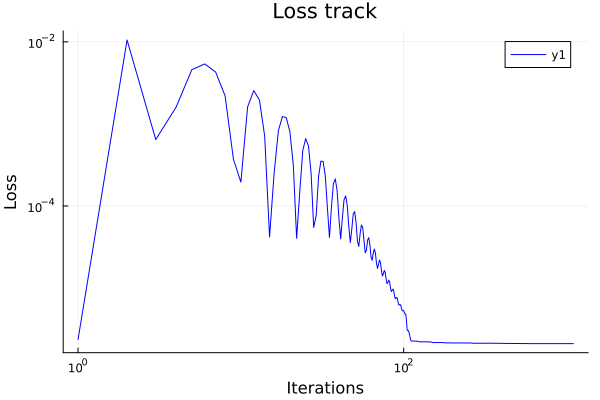

In [50]:
begin
	# Plot the losses
	pl_losses = plot(1:length(losses), losses, yaxis = :log10, xaxis = :log10,
	                 xlabel = "Iterations", ylabel = "Loss", color = :blue, title="Loss track")
end

#### Visualise results



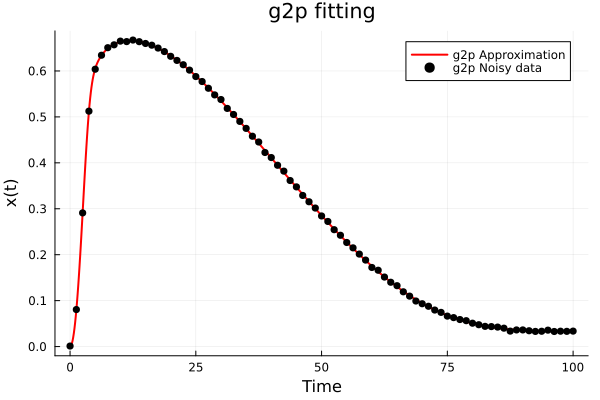

In [51]:
begin
	# retrieve the trained parameters and get NFB model estimations
	p_trained = res2.u 
	ts = first(X.t):(mean(diff(X.t))):last(X.t) 
	X̂ = predict(p_trained, ts)
	
    # Trained on noisy data vs real solution
	pl_trajectory = plot(ts, X̂[2,:], xlabel = "Time", ylabel = "x(t)", color = :red, label = "g2p Approximation", linewidth=2, title="g2p fitting")
	scatter!(time, xₙ_g2p, color = :black, label = "g2p Noisy data")
end

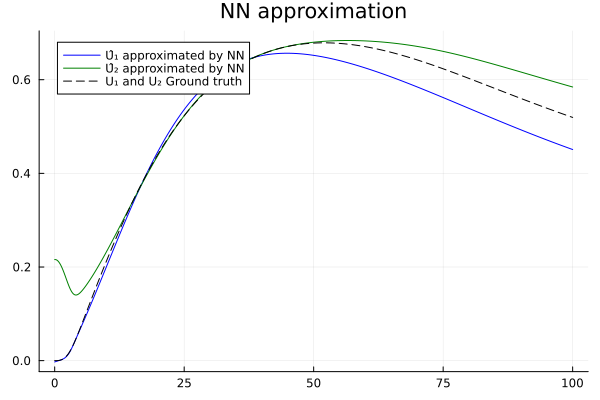

In [52]:
begin
	# Compare unknown part approximated by NN with ground truth
	û = U(X̂, p_trained, _st)[1]
	nn_plot = plot(ts, û[1,:], label="Û₁ approximated by NN", colour=:blue, title="NN approximation")
	plot!(nn_plot, ts, û[2,:], label="Û₂ approximated by NN", colour=:green)
	if nfb_type == "a"
		plot!(nn_plot, ts, X[3,:], label="U₁ Ground truth", colour=:blue, linestyle=:dash)
		plot!(nn_plot, ts, repeat([1], length(ts)), label="U₂ Ground truth", colour=:green, linestyle=:dash)
	elseif nfb_type == "b"
		plot!(nn_plot, ts, repeat([1], length(ts)), label="U₁ Ground truth", colour=:blue, linestyle=:dash)
		plot!(nn_plot, ts, X[3,:], label="U₂ Ground truth", colour=:green, linestyle=:dash)
	elseif nfb_type == "ab"
		plot!(nn_plot, ts, X[3,:], label="U₁ and U₂ Ground truth", colour=:black, linestyle=:dash)
	else
		plot!(nn_plot, ts, repeat([1], length(ts)), label="U₁ and U₂ Ground truth", colour=:black, linestyle=:dash, ylim=(0.95, 1.05))
	end
end

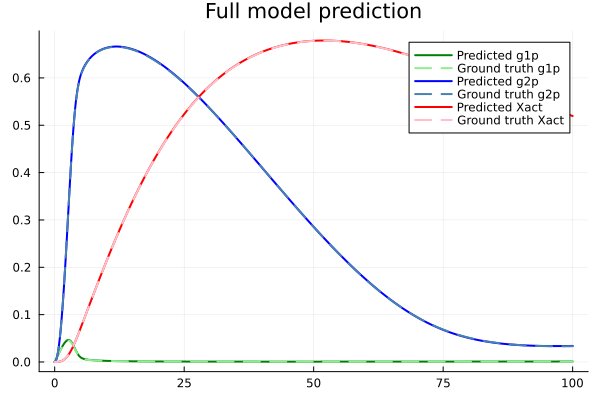

In [54]:
begin
	# Compare some predicted state variables with their respective ground truth
	plot(ts, X̂[1,:], label="Predicted g1p", colour=:green, linewidth=2, title="Full model prediction")
	plot!(X.t, X[1,:], label="Ground truth g1p", linestyle=:dash, colour=:lightgreen, linewidth=2)
	plot!(ts, X̂[2,:], label="Predicted g2p", colour=:blue, linewidth=2)
	plot!(X.t, X[2,:], label="Ground truth g2p", linestyle=:dash, colour=:steelblue, linewidth=2)
	plot!(ts, X̂[3,:], label="Predicted Xact", colour=:red, linewidth=2)
	plot!(X.t, X[3,:], label="Ground truth Xact", colour=:pink, linewidth=2, linestyle=:dash)
end


##### Save results



In [55]:
# Save animation data
#jldsave("./Data/nfb_anim_data.jld2"; anim_data=(track=track, df=df))

In [56]:
# Save the parameters
if !isnothing(save_file)
	#jldsave(save_file; architecture = (p=res2.u, st=_st))
end

In [57]:
begin
	# Save NN approximation with the fitted and GT ODE solution for equation discovery
	g2p_data = zeros(length(X[1,:]))
	time_data = zeros(length(X[1,:]))
	g2p_data[begin:length(xₙ_g2p)] = xₙ_g2p
	time_data[begin:length(time)] = time
	df = DataFrame((
		time=X.t,
		t_data=time_data,
		g2p_data=g2p_data,
		NN1=û[1,:],
		NN2=û[2,:],
		g1p_fit=X̂[1,:],
		g2p_fit=X̂[2,:],
		Xact_fit=X̂[3,:],
		g1p_GT=X[1,:],
		g2p_GT=X[2,:],
		Xact_GT=X[3,:],
		))
	if !isnothing(filename)
		#CSV.write("./Data/$(filename).csv", df, header=true)
	end
end